In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))


refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [2]:
figI = 0
# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
no_layers = len(bs_true)
# no_layers = 3
layers = []
names = []
#names = ['layer1','layer2']
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
        sld = SLD(bs[i],name=names[i])
        layers.append(sld(thicks[i],roughs[i]))
structure = layers[0]
for layer in layers[1:]:
    structure|=layer
print("done")

done


<IPython.core.display.Javascript object>


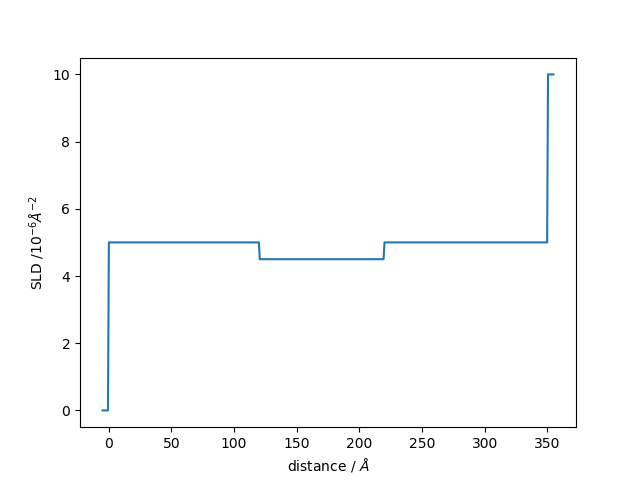

done


In [3]:
%matplotlib notebook
plt.figure(figI)
figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [5]:
resolution = 5.
model = ReflectModel(structure, bkg=3e-6, dq=resolution)

<IPython.core.display.Javascript object>


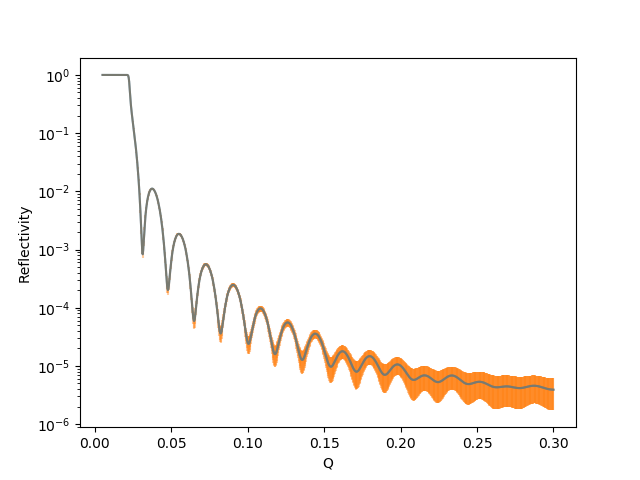

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


<ErrorbarContainer object of 3 artists>

In [6]:
q = np.linspace(0.005, 0.3, 1001)
plt.figure(figI)
figI+=1
R = model(q, x_err=resolution)
plt.plot(q, R)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale('log')
#Q, R(Q), sig_Q, sig_R =
import make_sim_data as msd
sim_dR = msd.main(sim_q=q,sim_R=R)*10
R = model(q, x_err=resolution)
plt.errorbar(q,R,sim_dR, alpha=0.4)

In [7]:
data = Data1D(data= (q,R,sim_dR))

In [8]:
from sepObjective import getObjective as gO
objective = gO(data, 3)
from CFitter import CFitter
# def ex
fitter = CFitter(objective)
from dynesty import DynamicNestedSampler
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.01)
res = DNSampler.results # 07:18 mins


refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


29263it [09:30, 51.33it/s, batch: 8 | bound: 157 | nc: 9 | ncall: 144945 | eff(%): 20.189 | loglstar: 1542.480 < 1550.355 < 1548.741 | logz: 1525.145 +/-  0.290 | stop:  0.980]         


In [78]:
res.summary()

AttributeError: nlive

nlive does not excist though it should aparently.\
MultiEllipsoidSamplerSamples conditioned on the union of multiple (possibly overlapping) ellipsoids used to bound the set of live points.

logz max:  1525.1534491815144 ,min:  -269283.5930688626
z max:  inf ,min:  0.0


<IPython.core.display.Javascript object>


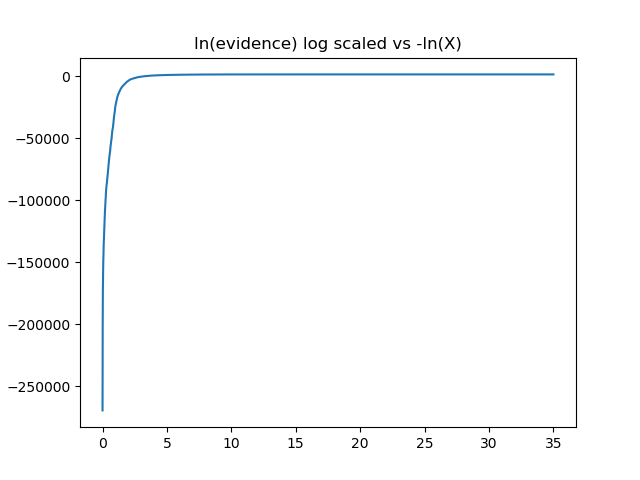

<IPython.core.display.Javascript object>


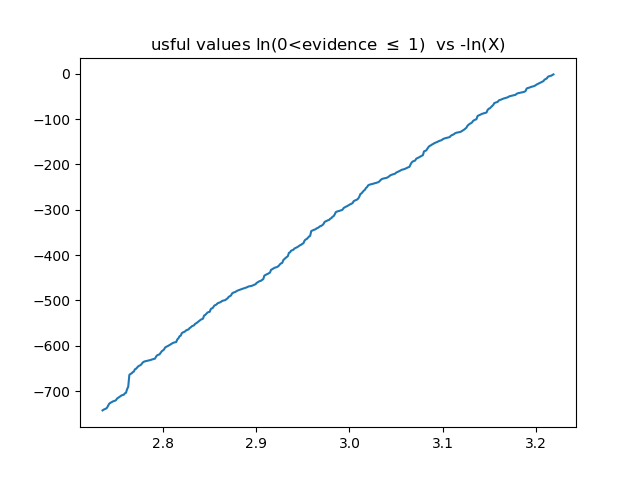

<IPython.core.display.Javascript object>


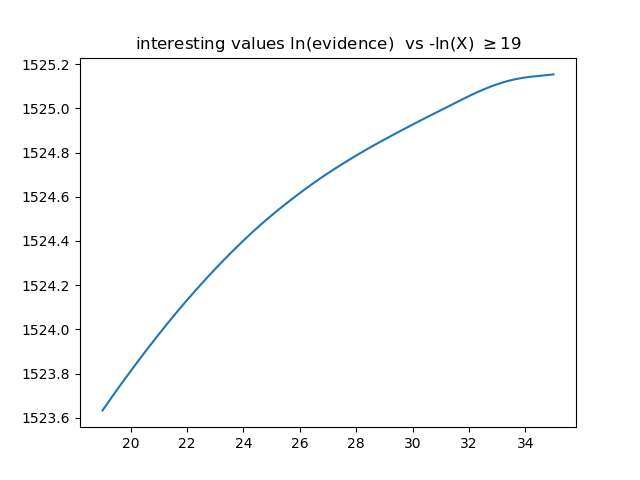

Text(0.5, 1.0, 'interesting values ln(evidence)  vs -ln(X) $\\geq 19$')

In [74]:
# no = -1000
# slc = slice(no-1000,no)
xall=np.linspace(0,35,len(res["logz"]))
useable=np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if np.exp(y)>0 and np.exp(y)<=1 ]))
# print(len(res["logz"]),res["logz"][slc])#summary()
interesting = np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if x>=19.]))
print("logz max: ",max(res["logz"]),",min: ",min(res["logz"]))
print("z max: ",max(np.exp(res["logz"])),",min: ",min(np.exp(res["logz"])))
# print("interesting")
xall=np.linspace(0,35,len(res["logz"]))
xusable=np.linspace(0,35,len(useable))
plt.figure(figI)
figI+=1
plt.plot(xall,res["logz"])
plt.title("ln(evidence) log scaled vs -ln(X)")
# plt.yscale("log")
plt.figure(figI)
figI+=1
plt.plot(useable[0],useable[1])
plt.title(r"usful values ln(0<evidence $\leq$ 1)  vs -ln(X)")
plt.figure(figI)
figI+=1
plt.plot(interesting[0],interesting[1])
plt.title(r"interesting values ln(evidence)  vs -ln(X) $\geq 19$")

calculation is taking ln(z) = ln(evidence) and taking the exponent

<IPython.core.display.Javascript object>


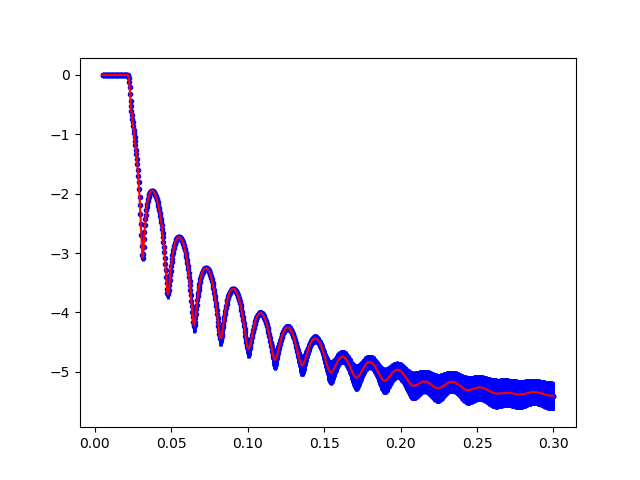

<IPython.core.display.Javascript object>


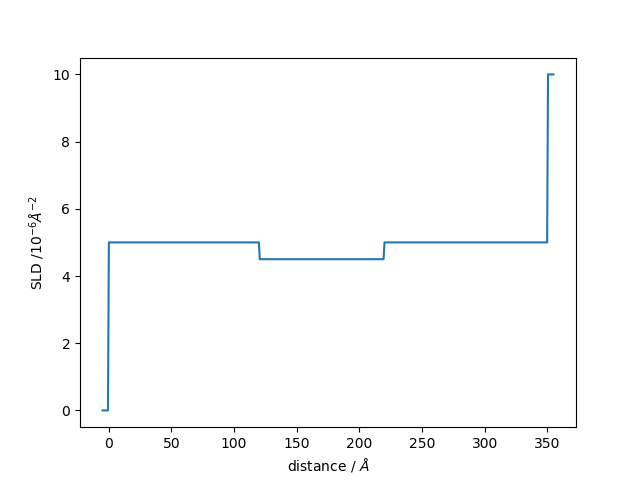

In [75]:
fig, ax = objective.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

<IPython.core.display.Javascript object>


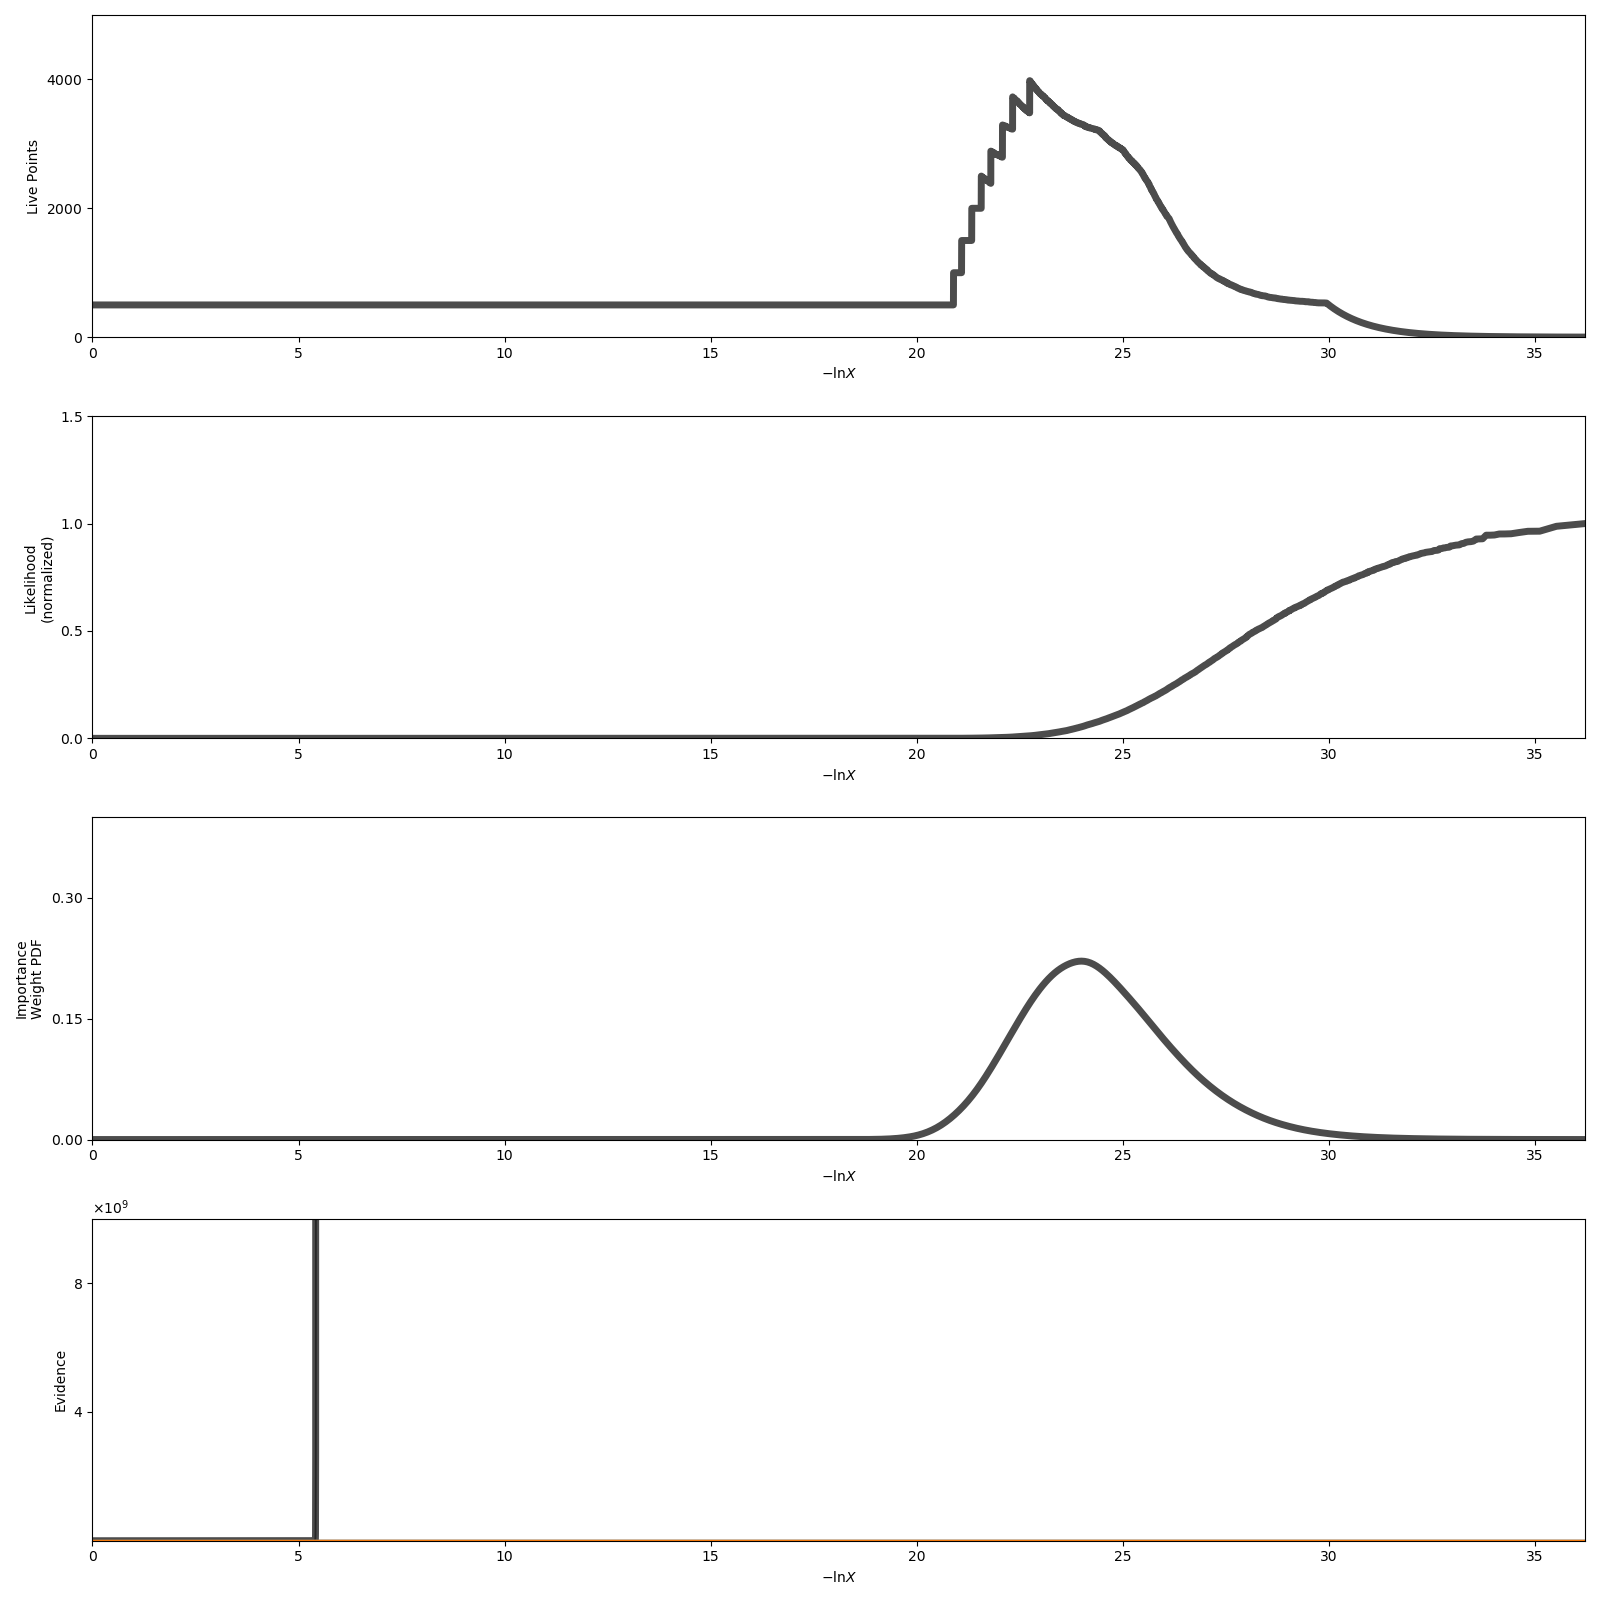

In [20]:
from dynesty import plotting as dyplot
# dyplot.runplot(res)
# fig, axes = plt.subplots(1,4)
# axes[0].set_xlim([0,36])
# axes[0].set_ylim([0,1000])
# axes[1].set_xlim([0,36])
# axes[1].set_ylim([0,1])
# axes[2].set_xlim([0,36])
# axes[2].set_ylim([0,1])
# axes[3].set_xlim([0,36])
# axes[3].set_ylim([0.00001,1])
span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**10)]
fig, axes = dyplot.runplot(res,span=span, color='black', mark_final_live=False,
                           logplot=False)#,fig=(fig, axes))  # static run
# fig, axes = dyplot.runplot(dres, color='red', logplot=True,
#                            fig=(fig, axes))  # default dynamic run
# fig, axes = dyplot.runplot(dres_p, color='blue', logplot=True,
#                            fig=(fig, axes))  # posterior dynamic run
# fig, axes = dyplot.runplot(dres_z, color='limegreen', logplot=True,
#                            lnz_truth=lnz_truth,  truth_color='orange',
#                            fig=(fig, axes))  # evidence dynamic run

fig.tight_layout()

<IPython.core.display.Javascript object>


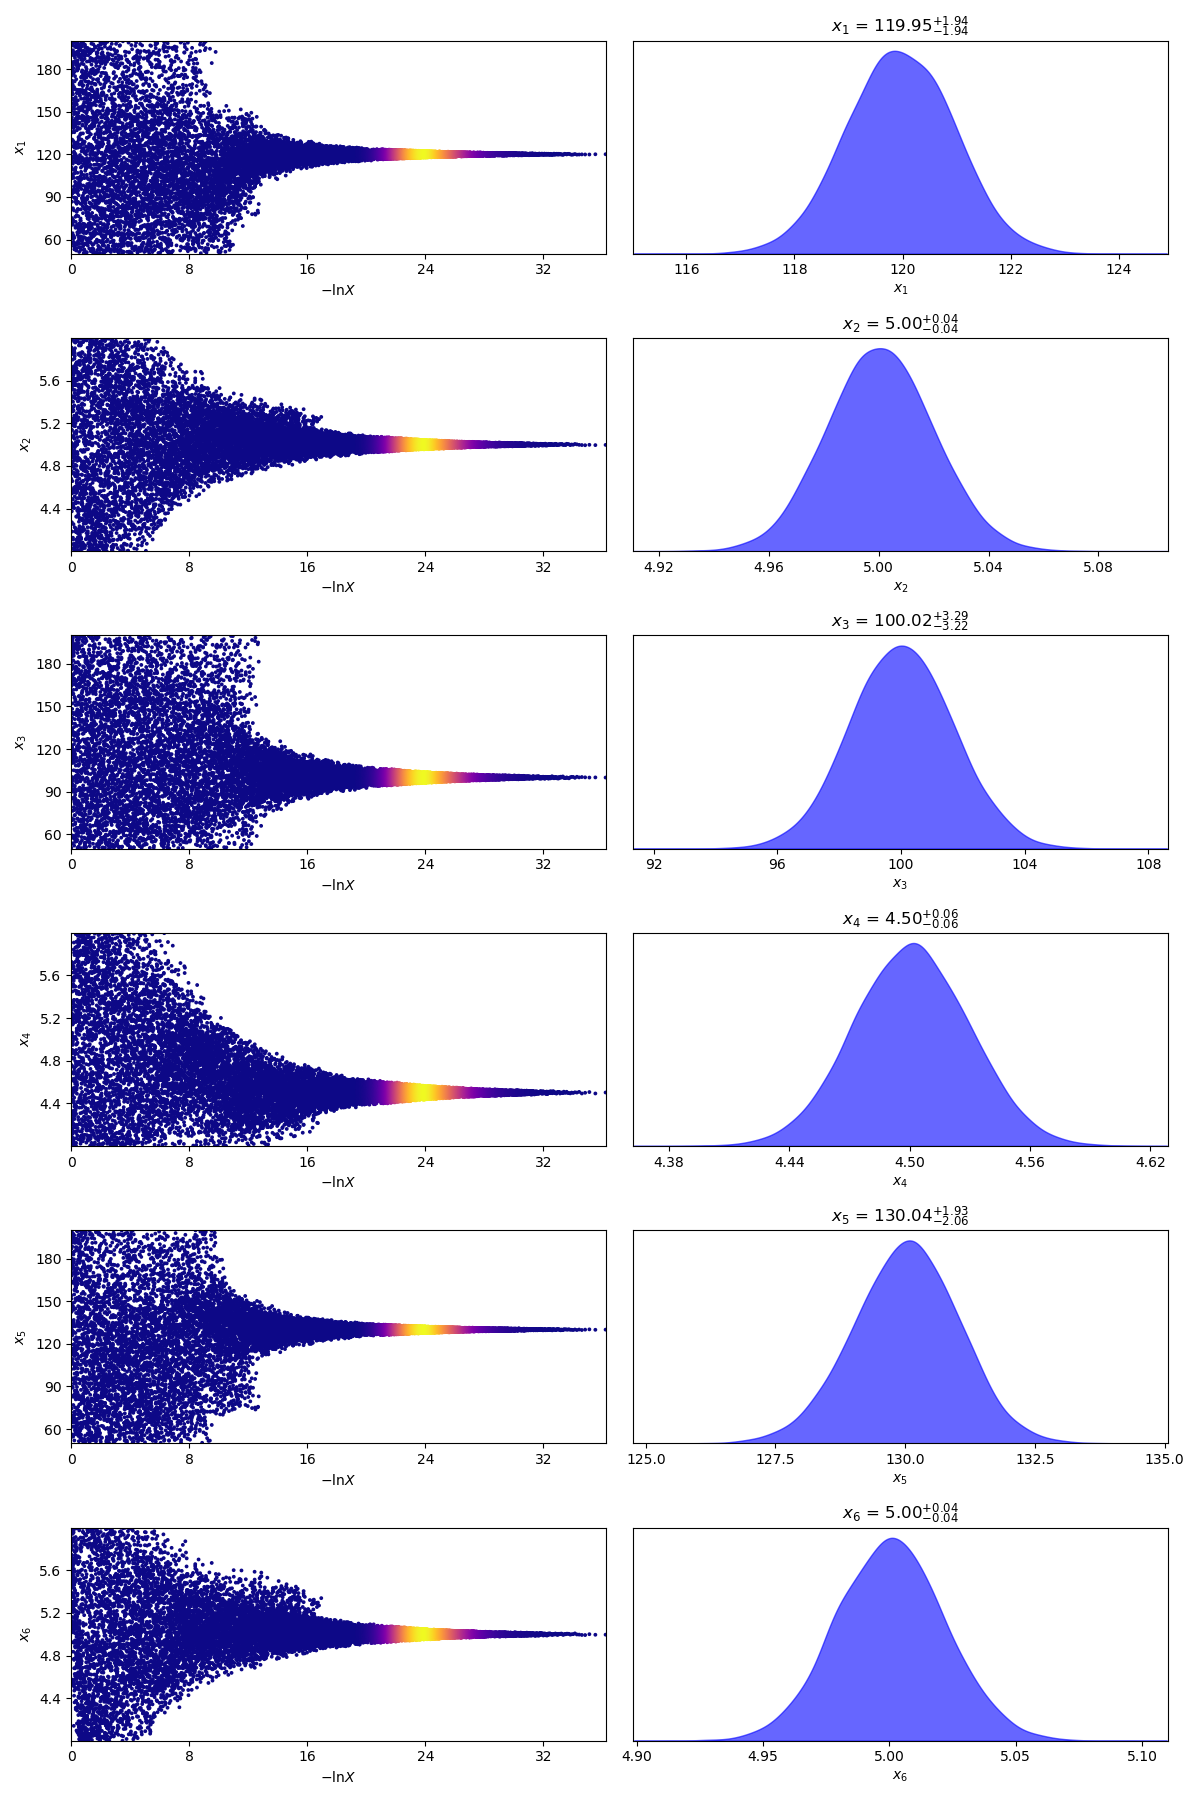

In [77]:
fig, axes = dyplot.traceplot(res, truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()